# Exercise 7.1

In [1]:
import scipy
import scipy.linalg
import scipy.sparse.linalg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import lanczos

In [2]:
L = 14
g = 1.5
J = 1.
sx_list = lanczos.gen_sx_list(L)
sz_list = lanczos.gen_sz_list(L)
H = lanczos.gen_hamiltonian(sx_list, sz_list, g, J)
E, vecs = scipy.sparse.linalg.eigsh(H, which='SA')
psi0 = vecs[:, 0]
print(E[0])
assert psi0.shape == (2**L, )
print(np.inner(psi0.conj(), H*psi0))

-23.40758298202158
-23.407582982021438


In [3]:
psi_ab = np.reshape(psi0, (2**(L//2), 2**(L//2)))
U, S, V = scipy.linalg.svd(psi_ab, full_matrices=False)
print(S[:30])

[9.64363389e-01 1.96659748e-01 1.73129130e-01 3.53057068e-02
 9.22437297e-03 3.91464555e-03 1.88109885e-03 1.65602271e-03
 7.98301984e-04 7.02784019e-04 3.37707768e-04 2.08343163e-04
 1.43316648e-04 4.24867995e-05 3.74445474e-05 3.74031937e-05
 2.48692057e-05 7.63595480e-06 7.62752166e-06 6.72230197e-06
 5.07150291e-06 4.46469039e-06 1.99285359e-06 1.37085898e-06
 9.10470987e-07 8.45728535e-07 4.82112240e-07 4.06396685e-07
 3.57770746e-07 2.37880069e-07]


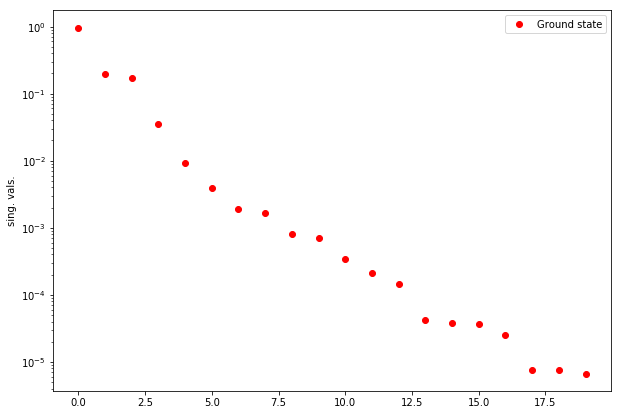

In [4]:
plt.figure(figsize=(10, 7))
plt.plot(S[:20], 'ro', label='Ground state')
plt.yscale('log')
plt.ylabel('sing. vals.')
plt.legend()

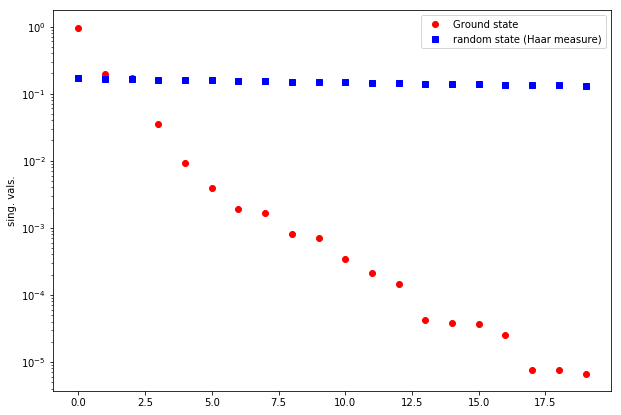

In [5]:
psi_rand = np.random.normal(size=psi0.shape) + 1.j * np.random.normal(size=psi0.shape)
psi_rand /= np.linalg.norm(psi_rand)
psi_rand_ab = np.reshape(psi_rand, (2**(L//2), 2**(L//2)))
_, S_rand, _ = scipy.linalg.svd(psi_rand_ab, full_matrices=False)
plt.figure(figsize=(10, 7))
plt.plot(S[:20], 'ro', label='Ground state')
plt.plot(S_rand[:20], 'bs', label='random state (Haar measure)')
plt.yscale('log')
plt.ylabel('sing. vals.')
plt.legend()

In [6]:
def entropy(S):
    S = np.asarray(S)
    S = S[S > 1.e-50] # useful if we have numerical rounding errors giving (small) negative S[alpha]
    # true since  x log(x) -> 0 for x -> 0.
    S2 = S*S
    return - np.sum(S2 * np.log(S2))

print(entropy(S))
print(entropy(S_rand))

0.30781949623119925
4.353075992576668


In [7]:
Ls = [6, 8, 10, 12, 14]
entr_rand = []
entr_gs = dict((g, []) for g in [0.1, 0.5, 1., 1.5, 4.])
for L in Ls:
    sx_list = lanczos.gen_sx_list(L)
    sz_list = lanczos.gen_sz_list(L)
    for g in entr_gs:
        H = lanczos.gen_hamiltonian(sx_list, sz_list, g, J)
        E, vecs = scipy.sparse.linalg.eigsh(H, which='SA')
        psi0 = vecs[:, 0]
        psi0_ab = np.reshape(psi0, (2**(L//2), 2**(L//2)))
        _, S0, _ = scipy.linalg.svd(psi0_ab, full_matrices=False)
        entr_gs[g].append(entropy(S0))
    
    psi_rand = np.random.normal(size=psi0.shape) + 1.j * np.random.normal(size=psi0.shape)
    psi_rand /= np.linalg.norm(psi_rand)
    psi_rand_ab = np.reshape(psi_rand, (2**(L//2), 2**(L//2)))
    _, S_rand, _ = scipy.linalg.svd(psi_rand_ab, full_matrices=False)
    entr_rand.append(entropy(S_rand))
    

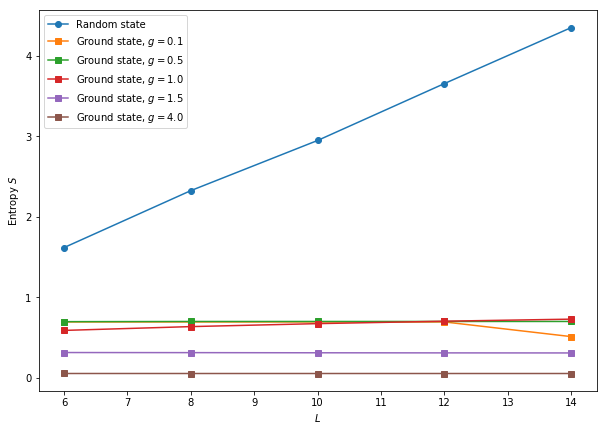

In [8]:
plt.figure(figsize=(10, 7))    
plt.plot(Ls, entr_rand, marker='o', label='Random state')
for g in sorted(entr_gs):
    plt.plot(Ls, entr_gs[g], marker='s', label="Ground state, $g={g:.1f}$".format(g=g))
plt.xlabel('$L$')
plt.ylabel('Entropy $S$')
plt.legend()
plt.show()
    

## Conclusion

If we draw a random state of the Hilberspace, we get a highly entangled state with a volume law, $ S \propto L$ in $1D$, where the Schmidt values are almost uniform.
In contrast, ground states of gapped systems satisfy an area law, which means $S \propto \mathrm{const}$.
Moreover, their Schmidt spectrum decays quickly (in many cases roughly exponentially fast).
Hence, we can represent ground states efficiently with MPS of small bond dimension (which does not need to increase with increasing $L$).
For criticall (=gapless) systems, the area law is not strictly true, but there are $\log$ corrections. However, note that the entanglement ist still small compared to random states with a volume law! Thus we still have a good chance to represent the state quite well with MPS even for quite large $L$.

Deep in the paramegnetic phase (large $g$), the state is aligned along the field with only few fluctuations, hence a very small $S$.
In the symmetry broken phase, the entanglement is higher by $\approx \log(2)$, since for finite systems the exact ground state is a superposition of $|\rightarrow\rightarrow\rightarrow\rightarrow\rightarrow \dots\rangle$ and
 $|\leftarrow\leftarrow\leftarrow\leftarrow\leftarrow \dots\rangle$ (each with a few fluctuations for non-zero $g$).

# Exercise 7.2

In [9]:
L = 14
g = 1.5
J = 1.
sx_list = lanczos.gen_sx_list(L)
sz_list = lanczos.gen_sz_list(L)
H = lanczos.gen_hamiltonian(sx_list, sz_list, g, J)
E, vecs = scipy.sparse.linalg.eigsh(H, which='SA')
psi0 = vecs[:, 0]
print("E =", E[0])
print("norm = ", np.linalg.norm(psi0)) # close enough :D

E = -23.407582982021687
norm =  1.0


In [10]:
def compress(psi, L, chimax):
    psi_aR = np.reshape(psi, (1, 2**L))
    Ms = []
    for n in range(1, L+1):
        chi_L, dim_R = psi_aR.shape
        assert dim_R == 2**(L-(n-1))
        psi_LR = np.reshape(psi_aR, (chi_L*2, dim_R//2))
        M_n, lambda_n, psi_tilde = scipy.linalg.svd(psi_LR, full_matrices=False, lapack_driver='gesvd')
        if len(lambda_n) > chimax:
            keep = np.argsort(lambda_n)[::-1][:chimax]
            M_n = M_n[:, keep]
            lambda_n = lambda_n[keep]
            psi_tilde = psi_tilde[keep, :]
        chi_np1 = len(lambda_n)
        M_n = np.reshape(M_n, (chi_L, 2, chi_np1))
        Ms.append(M_n)
        psi_aR = lambda_n[:, np.newaxis] * psi_tilde[:, :]
    assert psi_aR.shape == (1, 1)
    print("remaining in compress: ", psi_aR)
    return Ms        
        

In [11]:
psi0_MPS_ex = compress(psi0, L, 2**(L//2))
print("first M:")
print(psi0_MPS_ex[0])
print("second M:")
print(psi0_MPS_ex[1])

remaining in compress:  [[1.]]
first M:
[[[-1.00000000e+00  4.10178724e-16]
  [ 4.10178724e-16  1.00000000e+00]]]
second M:
[[[-9.85276619e-01 -1.22189585e-16 -1.17376782e-16 -1.70967787e-01]
  [-9.31611753e-17  7.07106781e-01  7.07106781e-01 -3.09214460e-16]]

 [[-2.61053995e-17 -7.07106781e-01  7.07106781e-01  4.33680869e-19]
  [ 1.70967787e-01 -4.26741975e-16 -1.83145800e-16 -9.85276619e-01]]]


In [12]:
psi0_MPS_compr = compress(psi0, L, 10)

remaining in compress:  [[0.99999958]]


In [13]:
print("total size of psi_MPS_ex =", sum([M.size for M in psi0_MPS_ex]))
print("total size of psi_MPS_compr =", sum([M.size for M in psi0_MPS_compr]))

total size of psi_MPS_ex = 43688
total size of psi_MPS_compr = 1688


In [14]:
def overlap(mps_bra, mps_ket):
    L = len(mps_bra)
    assert L == len(mps_ket)
    contr = np.ones((1,1)) # has indices (alpha_n*, alpha_n)
    for n in range(L):
        M_ket = mps_ket[n]  # has indices (alpha_n, j_n, alpha_{n+1})
        contr = np.tensordot(contr, M_ket , axes=(1, 0)) 
        # now contr has indices alpha_n*, j_n, alpha_{n+1}
        M_bra = mps_bra[n].conj()  # has indices (alpha_n*, j_n, alpha_{n+1}*)
        contr = np.tensordot(M_bra, contr, axes=([0, 1], [0, 1]))
    assert contr.shape == (1, 1)
    return contr.item()
        

In [15]:
print(overlap(psi0_MPS_ex, psi0_MPS_ex))

1.0000000000000002


In [16]:
print(overlap(psi0_MPS_ex, psi0_MPS_compr))
print("Still quite a good overlap, given that we have compressed the state quite much!")

0.9999995772646856
Still quite a good overlap, given that we have compressed the state quite much!


In [17]:
M_up = np.zeros((1, 2, 1))
M_up[0, 0, 0] = 1.
MPS_all_up = [M_up.copy() for i in range(L)]

In [18]:
print(overlap(psi0_MPS_ex, MPS_all_up))

0.7976402823035696
